In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import SmoothBivariateSpline

import sys
sys.path.append("../")

from electronfactors.model.threshold import angle_gap, fit_give

In [2]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)

In [3]:
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

In [4]:
own_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in own_label])
length = np.array([cutout_data[key]['length'] for key in own_label])
factor = np.array([cutout_data[key]['factor'] for key in own_label])

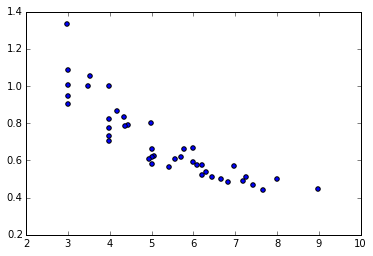

In [5]:
ratio = width/length
eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width

plt.scatter(width, eqPonA)

In [6]:
spline = SmoothBivariateSpline(width,eqPonA,factor,kx=2,ky=2)

In [7]:
x = np.arange(2,14,0.1)
y = x

xx, yy = np.meshgrid(x,y)
   
mesh_width = xx.copy()
mesh_width[xx>yy] = yy[xx>yy]

mesh_length = xx.copy()
mesh_length[yy>xx] = yy[yy>xx]

mesh_ratio = mesh_width / mesh_length

mesh_eqPonA = 2*( 3*(mesh_ratio+1) - np.sqrt( (3*mesh_ratio+1)*(mesh_ratio+3) ) ) / mesh_width

zz = spline.ev(mesh_width, mesh_eqPonA)
give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor)
gap = angle_gap(mesh_width, mesh_eqPonA, width, eqPonA, 1, 1)

outOfTolerance = (give > 0.5) | (gap > 180)

zz[outOfTolerance] = np.nan
    
zz = np.floor(zz*1e4)/1e4

(0.0, 16.0, 0.0, 16.0)

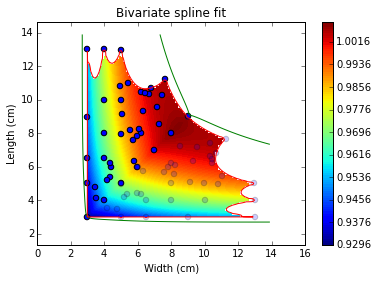

In [8]:
c = plt.contourf(xx,yy,zz,100)
plt.colorbar(c)

plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='r')

plt.scatter(width, length, s=30)
plt.scatter(length, width, s=30, alpha=0.2)

plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
plt.title('Bivariate spline fit')

plt.axis('equal')

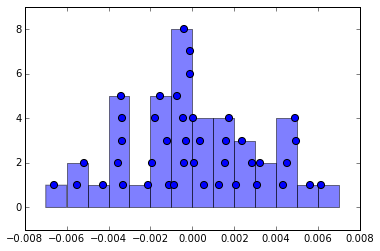

In [9]:
residuals_lengthwidth = factor - spline.ev(width, eqPonA)

binSize = np.floor(4 * residuals_lengthwidth.ptp() / len(residuals_lengthwidth) / 0.0005) * 0.0005
binStart = np.floor(residuals_lengthwidth.min()/binSize)*binSize
binEnd = np.ceil(residuals_lengthwidth.max()/binSize)*binSize

bins = np.arange(binStart,binEnd+binSize,binSize)

dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - residuals_lengthwidth),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):
    binRef = (binNum == i)
    representative_height[binRef] = np.arange(sum(binRef)) + 1

plt.hist(residuals_lengthwidth,bins,alpha=0.5)
plt.scatter(residuals_lengthwidth,representative_height,zorder=2,s=50,)

In [10]:
np.std(residuals_lengthwidth)

0.0030872810856269377